In [82]:
import pandas as pd
import numpy as np
import torch

from torch import nn
from torch.utils.data import Dataset, DataLoader
import transformers
from transformers import AdamW, BertConfig

import re
import os
import random
import time
import tqdm
from sklearn.metrics import mean_squared_error
import seaborn as sns

In [83]:
train_df = pd.read_csv("../input/funnysemval/data/task-1/train.csv")
valid_df = pd.read_csv("../input/funnysemval/data/task-1/dev.csv")
test_df = pd.read_csv("../input/funnysemval/data/task-1/test_without_label.csv")


In [84]:
test_d_label = pd.read_csv("../input/funnysemval/data/task-1/test_with_label.csv")

In [85]:
train_df.head()

,id,original,edit,grades,meanGrade
0,14530,France is ‘ hunting down its citizens who join...,twins,10000,0.2
1,13034,"Pentagon claims 2,000 % increase in Russian tr...",bowling,33110,1.6
2,8731,Iceland PM Calls Snap Vote as Pedophile Furor ...,party,22100,1.0
3,76,"In an apparent first , Iran and Israel <engage...",slap,20000,0.4
4,6164,Trump was told weeks ago that Flynn misled <Vi...,school,0,0.0


In [86]:
valid_df.head()

,id,original,edit,grades,meanGrade
0,1723,Thousands of gay and bisexual <men/> convicted...,swans,22100,1.0
1,12736,Special <prosecutor/> appointed to Trump Russia,chef,21100,0.8
2,12274,Spanish police detain man and search Ripoll ad...,squad,21000,0.6
3,8823,N.Y. Times <reprimands/> reporter for sharing ...,applauds,32210,1.6
4,5087,Vladimir Putin Releases Video Simulation Of Ru...,balloon,11000,0.4


In [87]:
test_df.head()

,id,original,edit
0,36,The Latest : Election tally shows <Austria/> t...,Cars
1,2157,House Intel <Republicans/> Have Cleared Trump ...,onions
2,9385,Christmas Is Canceled : Nazareth ’s Muslim <Ma...,grump
3,14434,White House says Trump 's legal <team/> suppor...,bozos
4,9462,Election <analysts/> move Ryan seat toward Dem...,movers


In [88]:
def get_pair(sent_orig, edit_word):
    o = re.sub("[</>]", "", sent_orig)
    e = (sent_orig.split("<"))[0] + edit_word + (sent_orig.split(">"))[1]

    return e, o

In [89]:
train_df.head()

,id,original,edit,grades,meanGrade
0,14530,France is ‘ hunting down its citizens who join...,twins,10000,0.2
1,13034,"Pentagon claims 2,000 % increase in Russian tr...",bowling,33110,1.6
2,8731,Iceland PM Calls Snap Vote as Pedophile Furor ...,party,22100,1.0
3,76,"In an apparent first , Iran and Israel <engage...",slap,20000,0.4
4,6164,Trump was told weeks ago that Flynn misled <Vi...,school,0,0.0


In [90]:
train_df.loc[0]['original']

'France is ‘ hunting down its citizens who joined <Isis/> ’ without trial in Iraq'

In [91]:
class SentencePair(Dataset):
    def __init__(self, dataframe, tokenizer, max_len=256):
        self.df = dataframe
        self.max_len = max_len
        self.tokenizer = tokenizer
        self.pad = self.tokenizer.pad_token_id
        self.cls = [self.tokenizer.cls_token_id]
        self.sep = [self.tokenizer.sep_token_id]

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        grade = torch.tensor(self.df["meanGrade"][idx],dtype=torch.float32)
        sent_e, sent_o = get_pair(self.df["original"][idx], self.df["edit"][idx])
        sent_e_tokens = (self.cls+ self.tokenizer.encode(sent_e, add_special_tokens=False)+ self.sep)
        sent_o_tokens = (self.tokenizer.encode(sent_o, add_special_tokens=False) + self.sep)
#         print(sent_e_tokens)
        token_type_ids = (torch.tensor([0] * len(sent_e_tokens) + [1] * (self.max_len - len(sent_e_tokens)))).long()
        attention_mask = torch.tensor([1] * (len(sent_o_tokens) + len(sent_e_tokens))+ [0] * (self.max_len - len(sent_o_tokens) - len(sent_e_tokens)))
        attention_mask = attention_mask.float()
        input_ids = torch.tensor(sent_o_tokens + sent_e_tokens)
#         print(input_ids)
#         print(attention_mask)
        if len(input_ids) < self.max_len:
            input_ids = torch.cat((input_ids,(torch.ones(self.max_len - len(input_ids)) * self.pad).long(),))
            token_type_ids = torch.cat((token_type_ids,(torch.ones(self.max_len - len(token_type_ids)) * self.pad).long(),))
        elif len(input_ids) > self.max_len:
            input_ids = input_ids[: self.max_len]
            token_type_ids = token_type_ids[: self.max_len]

        return input_ids, token_type_ids, attention_mask, grade

In [92]:


test_df['meanGrade']=[0]*len(test_df)


print(train_df.shape)
print(valid_df.shape)
print(test_df.shape)


(9652, 5)
(2419, 5)
(3024, 4)


In [93]:
test_df.reset_index(drop=True,inplace=True)

In [94]:
tokenizer = transformers.BertTokenizer.from_pretrained("bert-base-uncased")

train_df_ = SentencePair(train_df, tokenizer, max_len=256)


valid_df_ = SentencePair(valid_df, tokenizer, max_len=256)
test_df_ = SentencePair(test_df, tokenizer, max_len=256)


In [95]:
#  for i, data in enumerate(total_loader_1):
#         input_ids, token_type_ids, attention_mask, grade = data
#         print(input_ids,attention_mask)
#         break

train_loader=DataLoader(train_df_, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)



valid_loader=DataLoader(valid_df_, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

test_loader=DataLoader(test_df_, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)


In [96]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [97]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple,DataLoader)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [98]:
train_df.head()

,id,original,edit,grades,meanGrade
0,14530,France is ‘ hunting down its citizens who join...,twins,10000,0.2
1,13034,"Pentagon claims 2,000 % increase in Russian tr...",bowling,33110,1.6
2,8731,Iceland PM Calls Snap Vote as Pedophile Furor ...,party,22100,1.0
3,76,"In an apparent first , Iran and Israel <engage...",slap,20000,0.4
4,6164,Trump was told weeks ago that Flynn misled <Vi...,school,0,0.0


In [99]:

train_loader = to_device(train_loader,device)

valid_loader = to_device(valid_loader,device)

test_loader1 = to_device(test_loader,device)


In [100]:
model = transformers.BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=1).to(device,non_blocking=True)
# model = model.double()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [101]:
from transformers import get_linear_schedule_with_warmup
optimizer = AdamW(model.parameters(),lr = 2e-5, eps = 1e-8)
total_steps = len(train_loader) * 2
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [102]:
# #Fine tuning Bert for our task
preds = []
loss_stat =[]

training_stat=[]
# model.eval()
epochs=30
count=0
start_time = time.time()
for epoch in range(epochs):
    total_loss=0
    count=0
    print('== Epoch {:} / {:} =='.format(epoch + 1, epochs))
    print('Training for this epoch')
    for i, data in enumerate(train_loader):
        model.zero_grad()
        input_ids, token_type_ids, attention_mask, grade = data
        outputs = model(
            input_ids=input_ids,
            labels=grade,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
        )
        loss, logits = outputs[:2]
        loss.backward()
        optimizer.step()
        scheduler.step()
        total_loss+=loss.item()
        loss_stat.append(loss)
        for logit in logits.reshape(-1):
            preds.append(logit.item())
        count+=1
        print("Batch done out of 302:",count)
    
    avg_training_loss=total_loss/len(train_loader)
    print("Average training loss:",avg_training_loss)
    
    #Validation==============================
    #Uncomment this for validation loss 
    ## WARNING-> It will take lot of time 
    print("running validation")
    valid_preds=[]
    val_loss=0
    with torch.no_grad():
        for i, data in enumerate(valid_loader):
            input_ids, token_type_ids, attention_mask, grade = data
            outputs = model(
                input_ids=input_ids,
                labels=grade,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids,
            )
            loss, logits = outputs[:2]
            val_loss+=loss.item()
            for logit in logits.reshape(-1):
                valid_preds.append(logit.item())
        training_stat.append(
        {
            'epoch': epoch + 1,
            'Training Loss': avg_training_loss,
            'Valid. Loss': val_loss/len(valid_loader),
        }
        
    )
        print("--- %s seconds ---" % (time.time() - start_time))

print("--- %s seconds ---" % (time.time() - start_time))


== Epoch 1 / 30 ==
Training for this epoch
Batch done out of 302: 1
Batch done out of 302: 2
Batch done out of 302: 3
Batch done out of 302: 4
Batch done out of 302: 5
Batch done out of 302: 6
Batch done out of 302: 7
Batch done out of 302: 8
Batch done out of 302: 9
Batch done out of 302: 10
Batch done out of 302: 11
Batch done out of 302: 12
Batch done out of 302: 13
Batch done out of 302: 14
Batch done out of 302: 15
Batch done out of 302: 16
Batch done out of 302: 17
Batch done out of 302: 18
Batch done out of 302: 19
Batch done out of 302: 20
Batch done out of 302: 21
Batch done out of 302: 22
Batch done out of 302: 23
Batch done out of 302: 24
Batch done out of 302: 25
Batch done out of 302: 26
Batch done out of 302: 27
Batch done out of 302: 28
Batch done out of 302: 29
Batch done out of 302: 30
Batch done out of 302: 31
Batch done out of 302: 32
Batch done out of 302: 33
Batch done out of 302: 34
Batch done out of 302: 35
Batch done out of 302: 36
Batch done out of 302: 37
Batc

In [103]:
test_1 = []
count=0
with torch.no_grad():
    for i, data in enumerate(test_loader1):
        input_ids, token_type_ids, attention_mask, grade = data
        outputs = model(
            input_ids=input_ids,
            labels=grade,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
        )
        _, logits = outputs[:2]

        for logit in logits.reshape(-1):
            test_1.append(logit.item())
        count+=1
        print("Batch done out of 95:",count)

Batch done out of 95: 1
Batch done out of 95: 2
Batch done out of 95: 3
Batch done out of 95: 4
Batch done out of 95: 5
Batch done out of 95: 6
Batch done out of 95: 7
Batch done out of 95: 8
Batch done out of 95: 9
Batch done out of 95: 10
Batch done out of 95: 11
Batch done out of 95: 12
Batch done out of 95: 13
Batch done out of 95: 14
Batch done out of 95: 15
Batch done out of 95: 16
Batch done out of 95: 17
Batch done out of 95: 18
Batch done out of 95: 19
Batch done out of 95: 20
Batch done out of 95: 21
Batch done out of 95: 22
Batch done out of 95: 23
Batch done out of 95: 24
Batch done out of 95: 25
Batch done out of 95: 26
Batch done out of 95: 27
Batch done out of 95: 28
Batch done out of 95: 29
Batch done out of 95: 30
Batch done out of 95: 31
Batch done out of 95: 32
Batch done out of 95: 33
Batch done out of 95: 34
Batch done out of 95: 35
Batch done out of 95: 36
Batch done out of 95: 37
Batch done out of 95: 38
Batch done out of 95: 39
Batch done out of 95: 40
Batch don

In [104]:
print(mean_squared_error(test_d_label['meanGrade'].tolist(),test_1,squared=False))

0.5416581637756431

<AxesSubplot:>

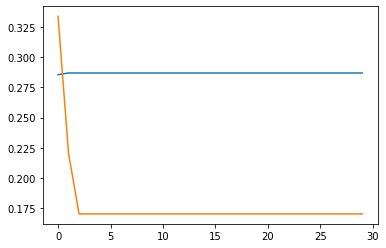

In [105]:
training_loss = []
valid_loss = []
for stat in training_stat:
    training_loss.append(stat['Training Loss'])
    valid_loss.append(stat['Valid. Loss'])
sns.lineplot(data=valid_loss)
sns.lineplot(data=training_loss)

In [107]:
import pickle 
with open('final_task1_preds.pickle', 'wb') as handle:
    pickle.dump(model , handle, protocol=pickle.HIGHEST_PROTOCOL)